energy consumption vs unemployment: https://www.kaggle.com/jayrav13/unemployment-by-county-us
energy consumption vs storms / weather

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 90)
import warnings
warnings.filterwarnings('ignore')

In [2]:
""" 
AEP = pd.read_csv("AEP_hourly.csv", memory_map=True)
COMED = pd.read_csv("COMED_hourly.csv", memory_map=True)
DAYTON = pd.read_csv("DAYTON_hourly.csv", memory_map=True)
DEOK = pd.read_csv("DEOK_hourly.csv", memory_map=True)
DOM = pd.read_csv("DOM_hourly.csv", memory_map=True)
DUQ = pd.read_csv("DUQ_hourly.csv", memory_map=True)
EKPC = pd.read_csv("EKPC_hourly.csv", memory_map=True)
FE = pd.read_csv("FE_hourly.csv", memory_map=True)
NI = pd.read_csv("NI_hourly.csv", memory_map=True)
PJM_est = pd.read_csv("pjm_hourly_est.csv", memory_map=True)
PJM_Load = pd.read_csv("PJM_Load_hourly.csv", memory_map=True)
PJME = pd.read_csv("PJME_hourly.csv", memory_map=True)
PJMW = pd.read_csv("PJMW_hourly.csv", memory_map=True)
"""

energy_gdp_by_state_10_14 = pd.read_csv("Census_and_economic_2010_2014.csv", memory_map=True) 
unemployment_90_16 = pd.read_csv("unemployment_by_county.csv", memory_map=True)
gdp_per_cap_92_16 = pd.read_csv("gdp_per_capita.csv", memory_map=True)
gdp_per_cap_92_16.drop('Unnamed: 0', axis=1, inplace=True) 

In [3]:
# Get rid of all years not in our census dataset
unemp_10_14 = unemployment_90_16[(unemployment_90_16['Year']>=2010) & (unemployment_90_16['Year']<=2014)]

# Set index to index column
unemp_10_14.set_index(unemp_10_14.index)

# Remove columns that won't be used
unemp_10_14_short = unemp_10_14.drop(['Month', 'County'], axis=1)

# Set index to start at 0 again
unemp_10_14_short.set_index(np.arange(0,len(unemp_10_14_short), 1), inplace=True)

# Calculate the average unemployment rate for each state, by year. This removes all excess rows to keep just year, state and rate
unemp_10_14_avg = pd.Series.to_frame(unemp_10_14_short.groupby(['Year','State'])['Rate'].mean())
unemp_10_14_avg.reset_index(inplace=True)
unemp_10_14_avg.head()

# Shorten even farther to have 1 row per state. Unemployment rate will then have 1 column for each year. 
# This format is to match the census file

unemp_avg_by_state = unemp_10_14_avg.pivot(index='State', columns='Year', values='Rate')
unemp_avg_by_state.reset_index(inplace=True)
unemp_avg_by_state.columns = ['State', 'Unemp_rate2010', 'Unemp_rate2011', 'Unemp_rate2012', 'Unemp_rate2013', 'Unemp_rate2014']


In [4]:
#Remove excess years not in the main table
gdp_per_cap_10_14 = gdp_per_cap_92_16[(gdp_per_cap_92_16['YEAR'] >= 2010)& (gdp_per_cap_92_16['YEAR'] <= 2014)]
gdp_per_cap_10_14.set_index(np.arange(0,len(gdp_per_cap_10_14),1), inplace=True)

#Pivot table to have 1 row per state like in the main table
gdp_by_state = gdp_per_cap_10_14.pivot(index='STATE', columns='YEAR', values='gdp_per_capita')
gdp_by_state.reset_index(inplace=True)
gdp_by_state.columns = ['State', 'GDP_per_cap2010', 'GDP_per_cap2011', 'GDP_per_cap2012', 'GDP_per_cap2013', 'GDP_per_cap2014']

The main table for this project contains 52 "states", 50 are actual states, and it includes 2 others:

* District of Columbia
* United States

By look at length and unique values, it was found that the unemployment table is missing 5 values from the main table:

* Alaska 
* Florida 
* Georgia 
* District of Columbia
* United States

By looking at the unique values it was found that the GDP table has 8 extra values from the main table:

* Far West
* Great Lakes
* Mideast
* New England
* Plains
* Rocky Mountain
* Southeast
* Southwest

Next step will be to clean up the main census file that contains 192 columns and 50 rows. Any missing data will be found, and correlations between different columns will begin to be explored.

* Can the table to transformed (pivot_table) so that each year is on its own row?
* If this is the way that will be used the pivot transformations of the 2 other tables will be removed
* The 3 tables then need to be merged and explored


In [5]:
first_2 = pd.merge(energy_gdp_by_state_10_14, gdp_by_state, left_on='State', right_on='State', how='left')
df = pd.merge(first_2, unemp_avg_by_state, left_on='State', right_on='State', how='left')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 0 to 51
Columns: 202 entries, StateCodes to Unemp_rate2014
dtypes: float64(104), int64(96), object(2)
memory usage: 82.5+ KB


In [6]:
# Separate out columns of our dataframe by year so we can have each row represent a year
cols_2010 = [col for col in df.columns if '2010' in col]
cols_2011 = [col for col in df.columns if '2011' in col]
cols_2012 = [col for col in df.columns if '2012' in col]
cols_2013 = [col for col in df.columns if '2013' in col]
cols_2014 = [col for col in df.columns if '2014' in col]
cols_diff_yrs = [col for col in df.columns if '-' in col]
other_cols = list(set(df.columns) - set(cols_2010) - set(cols_2011) - set(cols_2012) - set(cols_2013) - set(cols_2014) - set(cols_diff_yrs))

In [7]:
# Get columns of dataframe from previous lists of column names
cols_other_2010 = list(other_cols + cols_2010)
cols_other_2011 = list(other_cols + cols_2011)
cols_other_2012 = list(other_cols + cols_2012)
cols_other_2013 = list(other_cols + cols_2013)
cols_other_2014 = list(other_cols + cols_2014)
df_2010 = df[cols_other_2010]
df_2011 = df[cols_other_2011]
df_2012 = df[cols_other_2012]
df_2013 = df[cols_other_2013]
df_2014 = df[cols_other_2014]
df_2010.head()

StateCodes  Coast  Region       State  Division  Great Lakes  TotalC2010  \
0         AL    1.0     3.0     Alabama       6.0          0.0     1931522   
1         AK    1.0     4.0      Alaska       9.0          0.0      653221   
2         AZ    0.0     4.0     Arizona       8.0          0.0     1383531   
3         AR    0.0     3.0    Arkansas       7.0          0.0     1120632   
4         CA    1.0     4.0  California       9.0          0.0     7760629   

   TotalP2010  TotalE2010  TotalPrice2010  BiomassC2010  CoalC2010  CoalP2010  \
0     1419613     21630.5           17.82        169088     718684     493094   
1     1738207      6473.9           20.13          4178      14548      33556   
2      580948     19372.7           22.25         29289     457909     167930   
3     1247709     12269.4           16.90         94865     293689        718   
4     2532205    117090.0           20.97        280124      54972          0   

   CoalE2010  CoalPrice2010  ElecC2010  ElecE2010  ElecPrice2010  \
0     2135.6           2.97     310023     7833.0          26.44   
1       49.9           3.43      21315      912.4          43.29   
2      829.1           1.81     248506     7058.8          28.40   
3      510.6           1.74     164439     3393.3          21.57   
4      161.4           2.94     882107    33381.8          38.23   

   FossFuelC2010  GeoC2010  GeoP2010  HydroC2010  HydroP2010  NatGasC2010  \
0        1785688       138         0       84919        8704       544405   
1         634777       153         0       13982        1433       334978   
2        1292346       339         0       64606        6622       336208   
3         909827       773         0       35697        3659       274774   
4        5741492    124981     12600      326152       33431      2325411   

   NatGasE2010  NatGasPrice2010  LPGC2010  LPGE2010  LPGPrice2010  GDP2010Q1  \
0       3222.2             6.65     13088     316.7         24.20     172033   
1        479.2             6.41      1353      35.6         26.79      52307   
2       2198.8             6.86      7838     219.9         28.05     242824   
3       1791.7             7.23     10016     224.3         22.40     101063   
4      14914.1             6.97     63022    1669.8         27.58    1920145   

   GDP2010Q2  GDP2010Q3  GDP2010Q4     GDP2010  CENSUS2010POP  \
0     175198     178520     179132   176220.75        4779736   
1      53673      54846      56054    54220.00         710231   
2     246487     248985     251036   247333.00        2915918   
3     104880     106687     107085   104928.75        6392017   
4    1943428    1963650    2016517  1960935.00       37253956   

   POPESTIMATE2010  GDP_per_cap2010  Unemp_rate2010  
0          4785822            35913       12.360697  
1           713856            69564             NaN  
2          2922297            37935       13.060000  
3          6411999            34671        9.101111  
4         37336011            51871       13.893276

In [8]:
# Add Year column to each and drop year from individual column names
df_2010['Year'] = 2010
df_2011['Year'] = 2011
df_2012['Year'] = 2012
df_2013['Year'] = 2013
df_2014['Year'] = 2014

df_2010.columns = [col.replace('2010', '') for col in df_2010.columns]
df_2011.columns = [col.replace('2011', '') for col in df_2011.columns]
df_2012.columns = [col.replace('2012', '') for col in df_2012.columns]
df_2013.columns = [col.replace('2013', '') for col in df_2013.columns]
df_2014.columns = [col.replace('2014', '') for col in df_2014.columns]


In [9]:
df_full = pd.concat([df_2010, df_2011, df_2012, df_2013, df_2014], ignore_index=True, sort=True)
df_full.head()

BiomassC   CENSUSPOP   CoalC   CoalE   CoalP  CoalPrice  Coast  Division  \
0    169088   4779736.0  718684  2135.6  493094       2.97    1.0       6.0   
1      4178    710231.0   14548    49.9   33556       3.43    1.0       9.0   
2     29289   2915918.0  457909   829.1  167930       1.81    0.0       8.0   
3     94865   6392017.0  293689   510.6     718       1.74    0.0       7.0   
4    280124  37253956.0   54972   161.4       0       2.94    1.0       9.0   

    ElecC    ElecE  ElecPrice  FossFuelC         GDP    GDPQ1    GDPQ2  \
0  310023   7833.0      26.44    1785688   176220.75   172033   175198   
1   21315    912.4      43.29     634777    54220.00    52307    53673   
2  248506   7058.8      28.40    1292346   247333.00   242824   246487   
3  164439   3393.3      21.57     909827   104928.75   101063   104880   
4  882107  33381.8      38.23    5741492  1960935.00  1920145  1943428   

     GDPQ3    GDPQ4  GDP_per_cap    GeoC   GeoP  Great Lakes  HydroC  HydroP  \
0   178520   179132        35913     138      0          0.0   84919    8704   
1    54846    56054        69564     153      0          0.0   13982    1433   
2   248985   251036        37935     339      0          0.0   64606    6622   
3   106687   107085        34671     773      0          0.0   35697    3659   
4  1963650  2016517        51871  124981  12600          0.0  326152   33431   

    LPGC    LPGE  LPGPrice  NatGasC  NatGasE  NatGasPrice  POPESTIMATE  \
0  13088   316.7     24.20   544405   3222.2         6.65      4785822   
1   1353    35.6     26.79   334978    479.2         6.41       713856   
2   7838   219.9     28.05   336208   2198.8         6.86      2922297   
3  10016   224.3     22.40   274774   1791.7         7.23      6411999   
4  63022  1669.8     27.58  2325411  14914.1         6.97     37336011   

   RBIRTH  RDEATH  RDOMESTICMIG  RINTERNATIONALMIG  RNATURALINC  RNETMIG  \
0     NaN     NaN           NaN                NaN          NaN      NaN   
1     NaN     NaN           NaN                NaN          NaN      NaN   
2     NaN     NaN           NaN                NaN          NaN      NaN   
3     NaN     NaN           NaN                NaN          NaN      NaN   
4     NaN     NaN           NaN                NaN          NaN      NaN   

   Region       State StateCodes   TotalC    TotalE   TotalP  TotalPrice  \
0     3.0     Alabama         AL  1931522   21630.5  1419613       17.82   
1     4.0      Alaska         AK   653221    6473.9  1738207       20.13   
2     4.0     Arizona         AZ  1383531   19372.7   580948       22.25   
3     3.0    Arkansas         AR  1120632   12269.4  1247709       16.90   
4     4.0  California         CA  7760629  117090.0  2532205       20.97   

   Unemp_rate  Year  
0   12.360697  2010  
1         NaN  2010  
2   13.060000  2010  
3    9.101111  2010  
4   13.893276  2010

In [10]:
df_full.describe()

BiomassC     CENSUSPOP         CoalC         CoalE         CoalP  \
count  2.600000e+02  5.200000e+01  2.600000e+02    260.000000  2.600000e+02   
mean   1.680972e+05  1.187483e+07  7.223732e+05   1821.498846  8.042039e+05   
std    5.940948e+05  4.251612e+07  2.567657e+06   6472.319233  3.035151e+06   
min    8.190000e+02  5.636260e+05  0.000000e+00      0.000000  0.000000e+00   
25%    2.797425e+04  1.761651e+06  3.937975e+04    129.175000  0.000000e+00   
50%    6.835850e+04  4.436370e+06  3.021140e+05    636.600000  1.940000e+02   
75%    1.324628e+05  7.043661e+06  5.077322e+05   1523.300000  4.221975e+05   
max    4.611638e+06  3.087455e+08  2.082838e+07  50473.700000  2.205725e+07   

        CoalPrice      Coast    Division         ElecC          ElecE  \
count  260.000000  255.00000  255.000000  2.600000e+02     260.000000   
mean     2.633231    0.45098    5.117647  4.905118e+05   14282.506923   
std      0.973320    0.49857    2.514893  1.736620e+06   50659.732465   
min      0.000000    0.00000    1.000000  1.880300e+04     740.800000   
25%      1.990000    0.00000    3.000000  7.903100e+04    2088.025000   
50%      2.585000    0.00000    5.000000  1.961375e+05    5499.350000   
75%      3.365000    1.00000    8.000000  3.518022e+05    9624.625000   
max      4.900000    1.00000    9.000000  1.284516e+07  389871.500000   

        ElecPrice     FossFuelC           GDP         GDPQ1         GDPQ2  \
count  260.000000  2.600000e+02  2.600000e+02  2.600000e+02  2.600000e+02   
mean    30.733654  3.060784e+06  6.160688e+05  6.058749e+05  6.131483e+05   
std     11.530311  1.087910e+07  2.197262e+06  2.160755e+06  2.186693e+06   
min     18.270000  4.902500e+04  2.640650e+04  2.571500e+04  2.632100e+04   
25%     24.342500  6.061778e+05  8.375225e+04  8.244250e+04  8.267350e+04   
50%     27.080000  1.113105e+06  1.942938e+05  1.918160e+05  1.938130e+05   
75%     33.837500  1.787826e+06  4.173401e+05  4.128920e+05  4.168898e+05   
max     99.960000  8.089132e+07  1.723314e+07  1.686974e+07  1.715519e+07   

              GDPQ3         GDPQ4    GDP_per_cap           GeoC          GeoP  \
count  2.600000e+02  2.600000e+02     260.000000     260.000000    260.000000   
mean   6.196974e+05  6.255547e+05   49227.480769    8156.761538    598.080769   
std    2.210344e+06  2.231306e+06   18277.358258   33205.554662   2720.783706   
min    2.672900e+04  2.686100e+04   31167.000000       6.000000      0.000000   
25%    8.378875e+04  8.610425e+04   40421.500000     337.000000      0.000000   
50%    1.947330e+05  1.936980e+05   46228.500000     958.000000      0.000000   
75%    4.174525e+05  4.209722e+05   52029.500000    2042.000000      0.000000   
max    1.740699e+07  1.750064e+07  168030.000000  214490.000000  15877.000000   

       Great Lakes        HydroC         HydroP          LPGC          LPGE  \
count   255.000000  2.600000e+02     260.000000  2.600000e+02    260.000000   
mean      0.156863  1.023004e+05   10644.042308  1.140657e+05   2187.716923   
std       0.364386  3.811399e+05   39640.276827  4.577201e+05   8523.784320   
min       0.000000  0.000000e+00       0.000000  1.800000e+01      0.500000   
25%       0.000000  4.758500e+03     498.750000  7.701000e+03    190.350000   
50%       0.000000  1.361950e+04    1427.500000  1.115350e+04    314.650000   
75%       0.000000  3.470050e+04    3632.000000  2.810275e+04    688.775000   
max       1.000000  3.102852e+06  319355.000000  3.166737e+06  65197.200000   

         LPGPrice       NatGasC        NatGasE  NatGasPrice   POPESTIMATE  \
count  260.000000  2.600000e+02     260.000000   260.000000  2.600000e+02   
mean    26.405500  1.001217e+06    5966.972308     7.941769  1.208104e+07   
std      4.444317  3.575514e+06   21269.451525     4.957073  4.292796e+07   
min     13.860000  2.732000e+03      91.800000     3.270000  5.643580e+05   
25%     23.505000  1.617755e+05     742.125000     6.317500  1.781015e+06   
50%     26.250000  2.940025e+05    2004.950

In [11]:
# df_full.info()

In [12]:
# Dropping CENSUSPOP column due to missing ~80% of the data
df_full.drop(['CENSUSPOP'], axis=1, inplace=True)

In [13]:
# Break up consumption, expenditure, and production columns
consumption_cols = [col for col in df_full.columns if col[-1] == 'C']
expenditure_cols = [col for col in df_full.columns if col[-1] == 'E']
production_cols = [col for col in df_full.columns if col[-1] == 'P']
other_cols = list(set(df_full.columns) - set(consumption_cols) - set(expenditure_cols) - set(production_cols))

print(consumption_cols)
print(expenditure_cols)
print(production_cols)
print(other_cols)

['BiomassC', 'CoalC', 'ElecC', 'FossFuelC', 'GeoC', 'HydroC', 'LPGC', 'NatGasC', 'RNATURALINC', 'TotalC']
['CoalE', 'ElecE', 'LPGE', 'NatGasE', 'POPESTIMATE', 'TotalE']
['CoalP', 'GDP', 'GeoP', 'HydroP', 'TotalP']
['RNETMIG', 'Unemp_rate', 'GDPQ3', 'CoalPrice', 'LPGPrice', 'GDP_per_cap', 'TotalPrice', 'RDOMESTICMIG', 'Great Lakes', 'StateCodes', 'Coast', 'Region', 'State', 'ElecPrice', 'GDPQ4', 'Division', 'GDPQ1', 'NatGasPrice', 'Year', 'RINTERNATIONALMIG', 'RDEATH', 'GDPQ2', 'RBIRTH']


In [14]:
# Get column names for each energy type 
energy_types = ['Biomass', 'Coal', 'Elec', 'Geo', 'Hydro', 'NatGas', 'LPG', 'FossFuel']
energy_lists = [[], [], [], [], [], [], [], []]
non_energy = df_full.columns
for idx, energy in enumerate(energy_types):
    energy_lists[idx] = [col for col in df_full.columns if energy in col]
    non_energy = list(set(non_energy) - set(energy_lists[idx]))
print(energy_lists)
print(non_energy)

[['BiomassC'], ['CoalC', 'CoalE', 'CoalP', 'CoalPrice'], ['ElecC', 'ElecE', 'ElecPrice'], ['GeoC', 'GeoP'], ['HydroC', 'HydroP'], ['NatGasC', 'NatGasE', 'NatGasPrice'], ['LPGC', 'LPGE', 'LPGPrice'], ['FossFuelC']]
['POPESTIMATE', 'GDP', 'RNATURALINC', 'Unemp_rate', 'TotalE', 'TotalP', 'GDPQ3', 'GDP_per_cap', 'TotalPrice', 'RDOMESTICMIG', 'Great Lakes', 'StateCodes', 'Coast', 'Region', 'State', 'TotalC', 'GDPQ4', 'Division', 'GDPQ1', 'RINTERNATIONALMIG', 'Year', 'RNETMIG', 'RDEATH', 'GDPQ2', 'RBIRTH']


In [15]:
# Create separate dataframes for each energy type
df_list = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]
for idx, en_list in enumerate(energy_lists):
    df_list[idx] = df_full[list(non_energy + en_list)]


In [16]:
# Drop energy type from column, create new column for energy type
for idx, df_mini in enumerate(df_list):
    df_mini['Energy_type'] = energy_types[idx]
    df_mini.columns = [col.replace(energy_types[idx], '') for col in df_mini.columns]
print(df_list[1].columns)

Index(['POPESTIMATE', 'GDP', 'RNATURALINC', 'Unemp_rate', 'TotalE', 'TotalP',
       'GDPQ3', 'GDP_per_cap', 'TotalPrice', 'RDOMESTICMIG', 'Great Lakes',
       'StateCodes', 'Coast', 'Region', 'State', 'TotalC', 'GDPQ4', 'Division',
       'GDPQ1', 'RINTERNATIONALMIG', 'Year', 'RNETMIG', 'RDEATH', 'GDPQ2',
       'RBIRTH', 'C', 'E', 'P', 'Price', 'Energy_type'],
      dtype='object')


In [17]:
# Recombine the dataFrames, then rename the 'C', 'E', and 'P' columns
import functools
#df = reduce(lambda df1,df2: pd.merge(df1,df2,on='id'), dfList)
df_after = functools.reduce(lambda df1, df2: pd.merge(df1, df2, how='outer'), df_list)
df_after.rename(columns={'C':'Consumption', 'E':'Expenditure', 'P':'Production', 'TotalE':'TotalExpenditures', 'TotalP':'TotalProduction', 'TotalC':'TotalConsumption'}, inplace=True)


In [18]:
df_after[df_after.Energy_type == 'FossFuel'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 1820 to 2079
Data columns (total 30 columns):
POPESTIMATE          260 non-null int64
GDP                  260 non-null float64
RNATURALINC          208 non-null float64
Unemp_rate           235 non-null float64
TotalExpenditures    260 non-null float64
TotalProduction      260 non-null int64
GDPQ3                260 non-null int64
GDP_per_cap          260 non-null int64
TotalPrice           260 non-null float64
RDOMESTICMIG         204 non-null float64
Great Lakes          255 non-null float64
StateCodes           260 non-null object
Coast                255 non-null float64
Region               255 non-null float64
State                260 non-null object
TotalConsumption     260 non-null int64
GDPQ4                260 non-null int64
Division             255 non-null float64
GDPQ1                260 non-null int64
RINTERNATIONALMIG    208 non-null float64
Year                 260 non-null int64
RNETMIG              208 no

In [19]:
# Fill missing price and expenditure values with 0, since energy types that are missing price are hydro, geo, and bio
# These don't cost anything 
df_after[df_after.Price.isnull()]['Energy_type'].unique()
df_after['Price'].fillna(0, inplace=True)
df_after['Expenditure'].fillna(0,inplace=True)

In [20]:
# The missing values for production are for 'Biomass', 'Elec', 'NatGas', 'LPG' which are types that can't be produced
df_after[df_after.Production.isnull()]['Energy_type'].unique()
df_after['Production'].fillna(0, inplace=True)

In [21]:
# Missing migration rates for 2010, will fill those with the average for the column
df_after[df_after.RNETMIG.isnull()]['Year'].unique()
df_after['RNATURALINC'].fillna(df_after['RNATURALINC'].mean(), inplace=True)
df_after['RBIRTH'].fillna(df_after['RBIRTH'].mean(), inplace=True)
df_after['RDOMESTICMIG'].fillna(df_after['RDOMESTICMIG'].mean(), inplace=True)
df_after['RDEATH'].fillna(df_after['RDEATH'].mean(), inplace=True)
df_after['RINTERNATIONALMIG'].fillna(df_after['RINTERNATIONALMIG'].mean(), inplace=True)
df_after['RNETMIG'].fillna(df_after['RNETMIG'].mean(), inplace=True)

In [22]:
# Since United States isn't a state, and its the only one missing values in 'Division', 'Great Lakes', 'Coast', 'Region'
df_after[df_after['Region'].isnull()]['State'].unique()
df_after = df_after[df_after.State != 'United States']


In [23]:
df_after['Unemp_rate'].fillna(df_after['Unemp_rate'].mean(), inplace=True)
df_after.describe()

POPESTIMATE           GDP  RNATURALINC   Unemp_rate  \
count  2.040000e+03  2.040000e+03  2040.000000  2040.000000   
mean   6.158962e+06  3.140743e+05     4.230561     7.834320   
std    6.915529e+06  3.843210e+05     2.126355     2.165983   
min    5.643580e+05  2.640650e+04    -0.776457     3.094713   
25%    1.612843e+06  7.443275e+04     3.056161     6.233333   
50%    4.383465e+06  1.901705e+05     4.234652     7.834320   
75%    6.822112e+06  4.027890e+05     5.328165     9.077042   
max    3.880250e+07  2.324996e+06    13.207220    13.893276   

       TotalExpenditures  TotalProduction         GDPQ3    GDP_per_cap  \
count        2040.000000     2.040000e+03  2.040000e+03    2040.000000   
mean        26408.778431     1.477022e+06  3.159242e+05   49247.894118   
std         28712.092808     2.474686e+06  3.865645e+05   18423.802352   
min          2218.200000     9.500000e+01  2.672900e+04   31167.000000   
25%          7884.500000     2.483700e+05  7.536500e+04   40193.000000   
50%         19670.700000     6.467380e+05  1.924280e+05   45884.000000   
75%         33423.700000     1.513859e+06  4.059560e+05   52099.000000   
max        163261.800000     1.759710e+07  2.352770e+06  168030.000000   

        TotalPrice  RDOMESTICMIG  Great Lakes        Coast       Region  \
count  2040.000000   2040.000000  2040.000000  2040.000000  2040.000000   
mean     21.837373      0.403579     0.156863     0.450980     2.666667   
std       3.756356      3.889483     0.363760     0.497713     1.041873   
min      13.790000    -13.754494     0.000000     0.000000     1.000000   
25%      19.390000     -1.484373     0.000000     0.000000     2.000000   
50%      21.330000      0.403579     0.000000     0.000000     3.000000   
75%      23.790000      1.920812     0.000000     1.000000     4.000000   
max      40.140000     23.189451     1.000000     1.000000     4.000000   

       TotalConsumption         GDPQ4     Division         GDPQ1  \
count      2.040000e+03  2.040000e+03  2040.000000  2.040000e+03   
mean       1.898986e+06  3.189102e+05     5.117647  3.088774e+05   
std        2.036808e+06  3.917688e+05     2.510573  3.771235e+05   
min        1.304120e+05  2.686100e+04     1.000000  2.571500e+04   
25%        6.400950e+05  7.525000e+04     3.000000  7.365700e+04   
50%        1.428433e+06  1.917910e+05     5.000000  1.878460e+05   
75%        2.411816e+06  4.131280e+05     8.000000  3.979030e+05   
max        1.289950e+07  2.360282e+06     9.000000  2.274103e+06   

       RINTERNATIONALMIG        Year      RNETMIG       RDEATH         GDPQ2  \
count        2040.000000  2040.00000  2040.000000  2040.000000  2.040000e+03   
mean            2.450947  2012.00000     2.852974     8.371682  3.125854e+05   
std             1.393866     1.41456     3.974441     1.072625  3.818826e+05   
min             0.557539  2010.00000   -10.884734     5.236680  2.632100e+04   
25%             1.454160  2011.00000     0.454262     7.855200  7.458700e+04   
50%             2.269191  2012.00000     2.856392     8.367475  1.898660e+05   
75%             2.574067  2013.00000     4.416764     8.970091  3.993660e+05   
max             6.883393  2014.00000    25.104485    11.812924  2.312827e+06   

            RBIRTH   Consumption   Expenditure    Production        Price  
count  2040.000000  2.040000e+03   2040.000000  2.040000e+03  2040.000000  
mean     12.602243  3.611719e+05   1545.897402  5.196470e+04     8.487995  
std       1.367070  8.447528e+05   3979.574793  4.194941e+05    12.870672  
min       9.313705  0.000000e+00      0.000000  0.000000e+00     0.000000  
25%      12.062215  9.696250e+03      0.000000  0.000000e+00     0.000000  
50%      12.602127  7.292000e+04      0.000000  0.000000e+00     0.000000  
75%      13.100544  3.390858e+05   1134.400000  0.000000e+00    15.157500  
max      18.577841  1.175266e+07  39424.100000  7.658286e+06    99.960000

In [24]:
# Set up categorical variables
df_after['StateCodes'] = df_after['StateCodes'].astype('category')
df_after['State'] = df_after['State'].astype('category')
df_after['Energy_type'] = df_after['Energy_type'].astype('category')
df_after['Region'] = df_after['Region'].astype('category')
df_after['Coast'] = df_after['Coast'].astype('category')
df_after['Division'] = df_after['Division'].astype('category')
df_after['Year'] = df_after['Year'].astype('category')

# Data Visualizations
Time to see what kinds of relationships we can find within the data. 

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

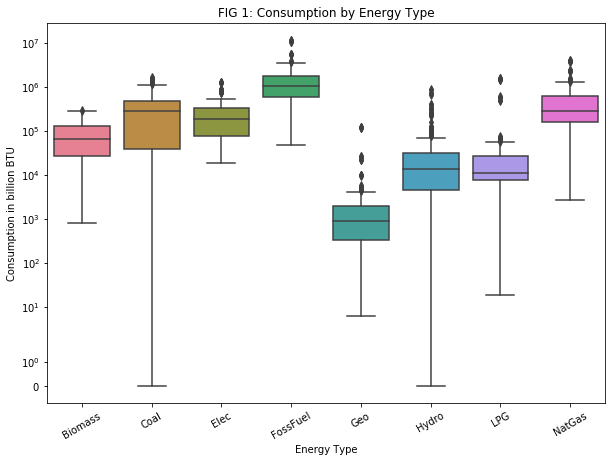

In [26]:
plt.figure(figsize=(10,7))
_ = sns.boxplot(x='Energy_type', y='Consumption', data=df_after, palette='husl')
plt.title("FIG 1: Consumption by Energy Type")
plt.xlabel("Energy Type")
plt.ylabel("Consumption in billion BTU")
_.set_yscale('symlog')
plt.xticks(rotation=30)
plt.show()

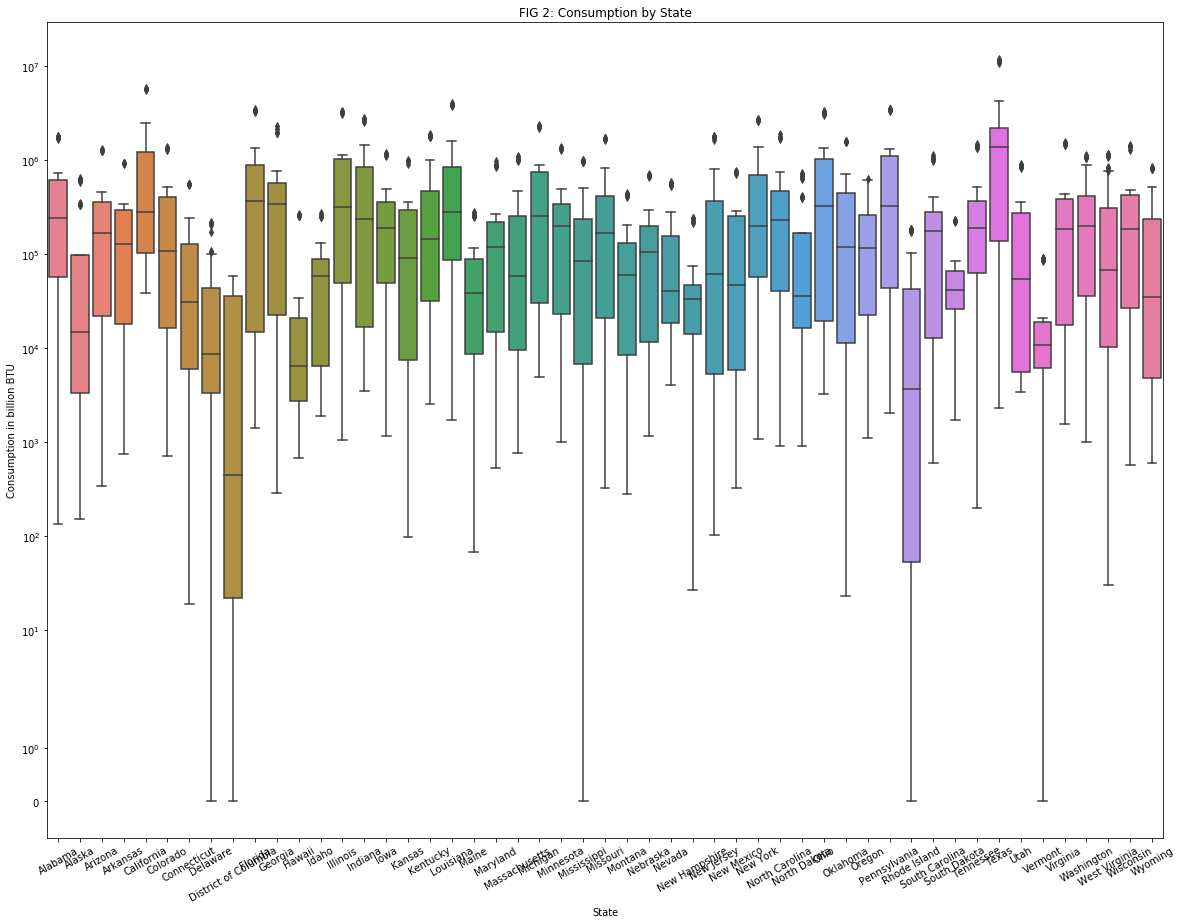

In [27]:
plt.figure(figsize=(20,15))
_ = sns.boxplot(x='State', y='Consumption', data=df_after, palette='husl')
plt.title("FIG 2: Consumption by State")
plt.xlabel("State")
plt.ylabel("Consumption in billion BTU")
_.set_yscale('symlog')
plt.xticks(rotation=30)
plt.show()

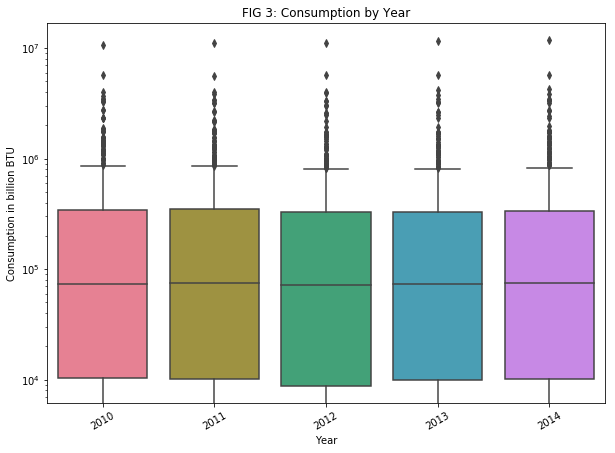

In [28]:
plt.figure(figsize=(10,7))
_ = sns.boxplot(x='Year', y='Consumption', data=df_after, palette='husl')
plt.title("FIG 3: Consumption by Year")
plt.xlabel("Year")
plt.ylabel("Consumption in billion BTU")
_.set_yscale('log')
plt.xticks(rotation=30)
plt.show()

The consumption breakdown by year shows that it's pretty consistent, but there is a slight increase each year. It doesn't seem that 'Year' will be a big determining factor in total consumption. However, both 'State' and 'Energy_type' show a lot of variability. 

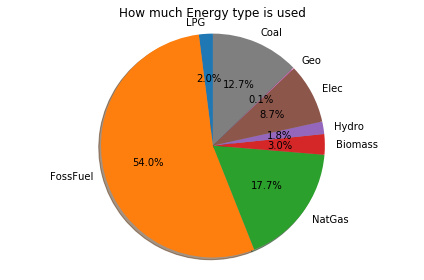

In [29]:
# Pie chart

labels = list(set(df_after.Energy_type))
sizes = []
tot_con = df_after.Consumption.sum()
for label in labels:
    sizes.append((df_after[df_after.Energy_type == label].Consumption.sum()) / tot_con)
    
# only "explode" the smallest (Geo) slice
explode = (0, 0, 0, 0, 0, 0, 0, 0)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal') 
plt.title('How much Energy type is used')
plt.tight_layout()
plt.show()

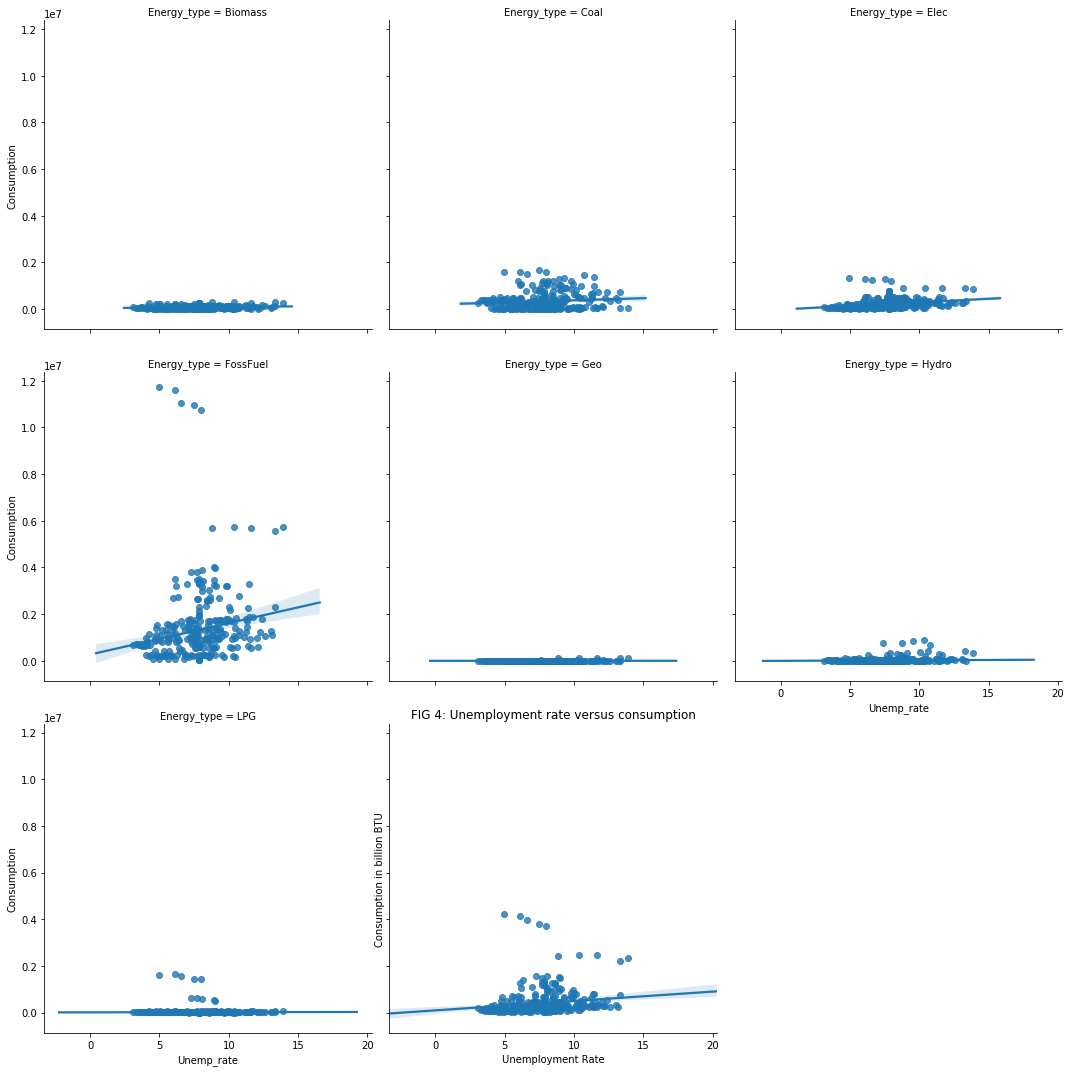

In [30]:
g = sns.lmplot(x="Unemp_rate", y="Consumption", col="Energy_type", col_wrap=3, data=df_after, robust=True)
plt.title("FIG 4: Unemployment rate versus consumption")
plt.xlabel("Unemployment Rate")
plt.ylabel("Consumption in billion BTU")
plt.show()

These graphs comparing the consumption vs the unemployment rate for each energy type show a slight positive trend, in that the higher the unemployment rate, the higher the energy consumption. This could be because when people are unemployed, they're at home more, consuming more energy.

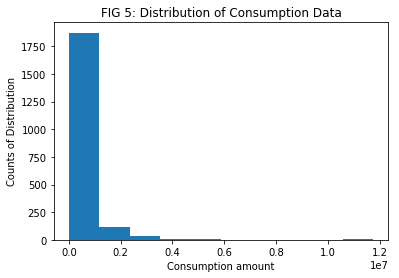

In [31]:
plt.hist(x=df_after.Consumption)
plt.title("FIG 5: Distribution of Consumption Data")
plt.xlabel("Consumption amount")
plt.ylabel("Counts of Distribution")
plt.show()

In [32]:
#Dropping top 10 highest  values that are causing graph to better view the majority of the data
df_after.sort_values('Consumption', inplace=True, ascending=False)
print(df_after.Consumption.describe())
df_after.head(15)
df_after_missing_high = df_after[df_after.Consumption < 2000000]

count    2.040000e+03
mean     3.611719e+05
std      8.447528e+05
min      0.000000e+00
25%      9.696250e+03
50%      7.292000e+04
75%      3.390858e+05
max      1.175266e+07
Name: Consumption, dtype: float64


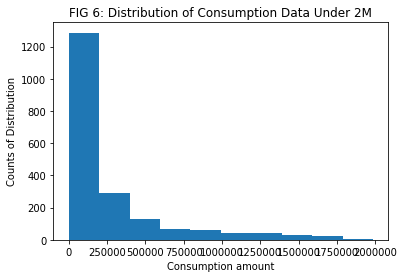

In [33]:
plt.hist(x=df_after_missing_high.Consumption)
plt.title("FIG 6: Distribution of Consumption Data Under 2M")
plt.xlabel("Consumption amount")
plt.ylabel("Counts of Distribution")
plt.show()

Even with dropping the high values, it is clear that our consumptiondata is exponentially distributed. 

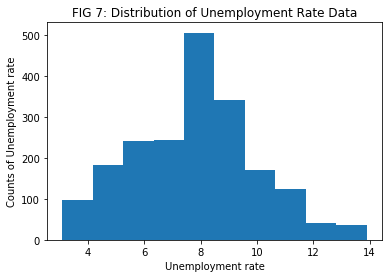

In [34]:
plt.hist(x=df_after_missing_high.Unemp_rate)
plt.title("FIG 7: Distribution of Unemployment Rate Data")
plt.xlabel("Unemployment rate")
plt.ylabel("Counts of Unemployment rate")
plt.show()

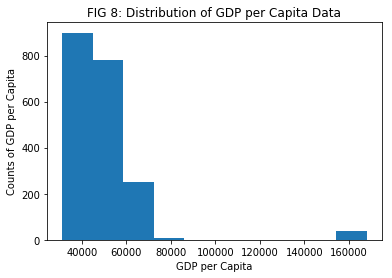

In [35]:
plt.hist(x=df_after_missing_high.GDP_per_cap)
plt.title("FIG 8: Distribution of GDP per Capita Data")
plt.xlabel("GDP per Capita")
plt.ylabel("Counts of GDP per Capita")
plt.show()

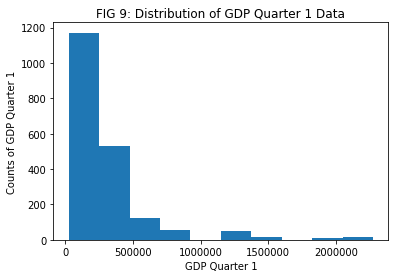

In [36]:
plt.hist(x=df_after_missing_high.GDPQ1)
plt.title("FIG 9: Distribution of GDP Quarter 1 Data")
plt.xlabel("GDP Quarter 1")
plt.ylabel("Counts of GDP Quarter 1")
plt.show()

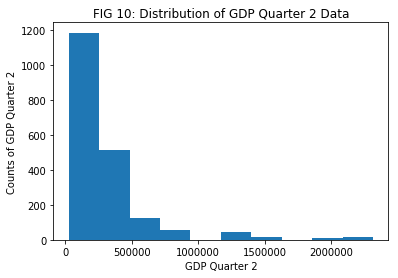

In [37]:
plt.hist(x=df_after_missing_high.GDPQ2)
plt.title("FIG 10: Distribution of GDP Quarter 2 Data")
plt.xlabel("GDP Quarter 2")
plt.ylabel("Counts of GDP Quarter 2")
plt.show()

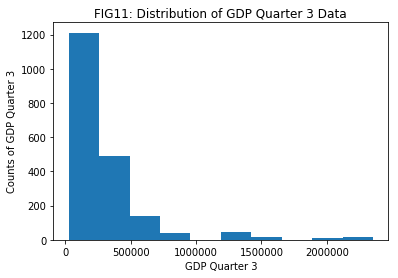

In [38]:
plt.hist(x=df_after_missing_high.GDPQ3)
plt.title("FIG11: Distribution of GDP Quarter 3 Data")
plt.xlabel("GDP Quarter 3")
plt.ylabel("Counts of GDP Quarter 3")
plt.show()

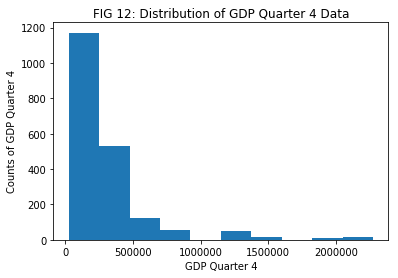

In [39]:
plt.hist(x=df_after_missing_high.GDPQ1)
plt.title("FIG 12: Distribution of GDP Quarter 4 Data")
plt.xlabel("GDP Quarter 4")
plt.ylabel("Counts of GDP Quarter 4")
plt.show()

While the unempolyment rate data appears to be normally distributed, but all for GDP Quarter data columns appear to be exponentially distributed like the energy consumption. The Quarter 1 GDP data looks to have the lowest max value.

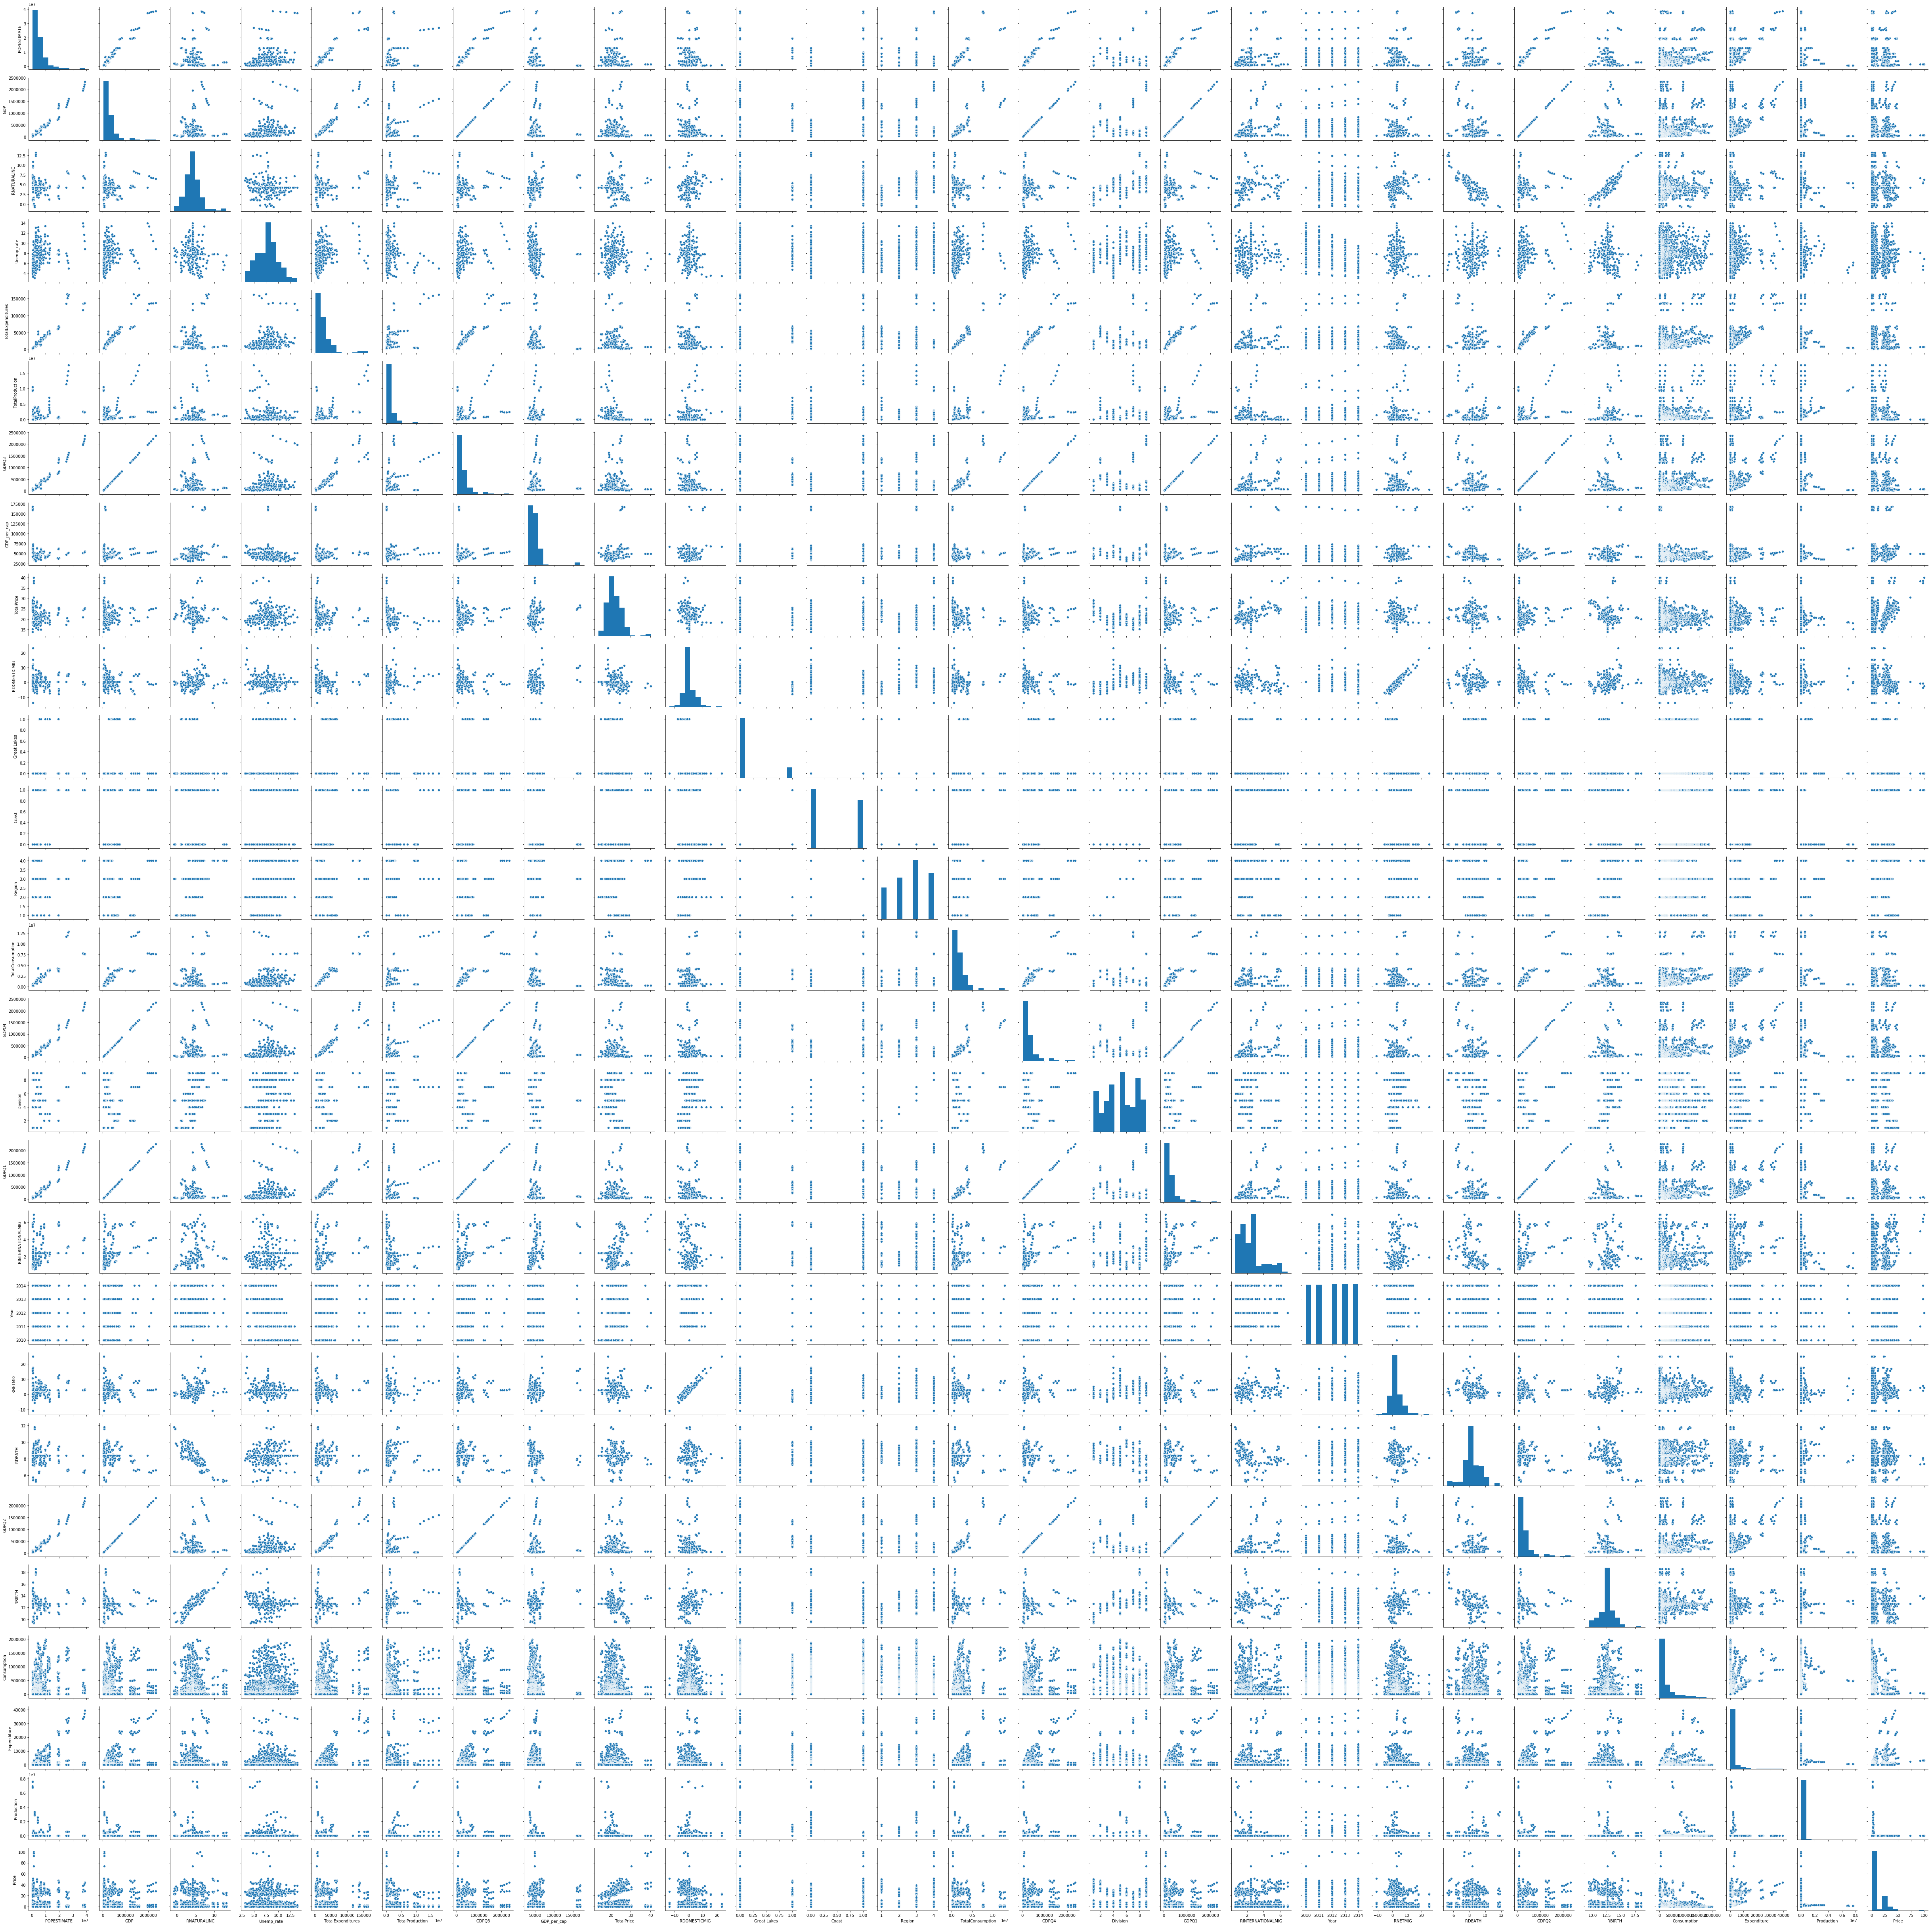

In [40]:
sns.pairplot(data=df_after_missing_high, palette='husl')
plt.show()

In [41]:
# For statistical analysis Hypothesize that the mean energy by household 
# (by person instead sine no household data?) each year is X 
# (google what the average household energy usage is each year)

# have to fix the fossilfuel data - getting another dataset with prices from EIA
